In [4]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import torch.nn as nn

In [1]:
# prompt: write code to connect with the google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load Dataset
data = pd.read_csv("/content/drive/My Drive/Glioma Grading.csv")

In [6]:
data.head()

,Case_ID,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Grade
0,TCGA-DU-8164,0,51.30,white,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-QH-A6CY,0,38.72,white,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-HW-A5KM,0,35.17,white,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-E1-A7YE,1,32.78,white,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,TCGA-S9-A6WG,0,31.51,white,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing

In [8]:

# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Fill missing values in numeric columns with their median
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Fill missing values in categorical columns with the mode (most frequent value)
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


In [10]:
# Basic statistics
print("\nSummary statistics for numerical columns:")
print(data.describe())


Summary statistics for numerical columns:
           Gender  Age_at_diagnosis        IDH1        TP53        ATRX  \
count  839.000000        839.000000  839.000000  839.000000  839.000000   
mean     0.418355         50.935411    0.481526    0.414779    0.258641   
std      0.493583         15.702339    0.499957    0.492978    0.438149   
min      0.000000         14.420000    0.000000    0.000000    0.000000   
25%      0.000000         38.055000    0.000000    0.000000    0.000000   
50%      0.000000         51.550000    0.000000    0.000000    0.000000   
75%      1.000000         62.800000    1.000000    1.000000    1.000000   
max      1.000000         89.290000    1.000000    1.000000    1.000000   

             PTEN        EGFR         CIC       MUC16      PIK3CA  ...  \
count  839.000000  839.000000  839.000000  839.000000  839.000000  ...   
mean     0.168057    0.133492    0.132300    0.116806    0.087008  ...   
std      0.374140    0.340309    0.339019    0.321380    0.

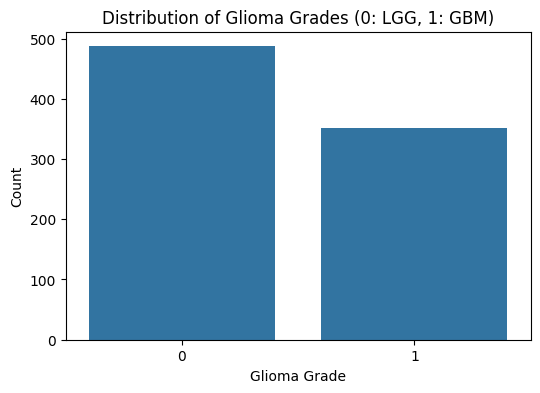

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Grade', data=data)
plt.title("Distribution of Glioma Grades (0: LGG, 1: GBM)")
plt.xlabel("Glioma Grade")
plt.ylabel("Count")
plt.show()


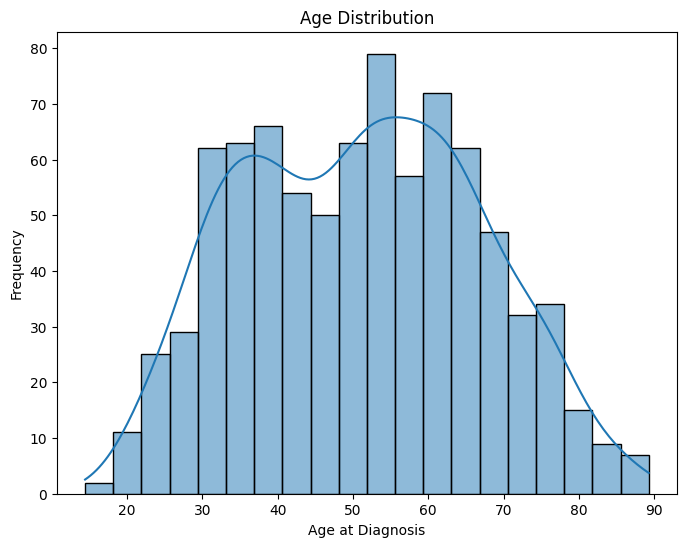

In [13]:
# Visualize distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(data['Age_at_diagnosis'], bins=20, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age at Diagnosis")
plt.ylabel("Frequency")
plt.show()

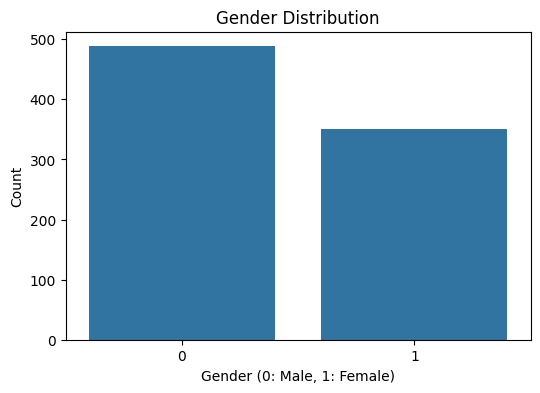

In [14]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=data)
plt.title("Gender Distribution")
plt.xlabel("Gender (0: Male, 1: Female)")
plt.ylabel("Count")
plt.show()


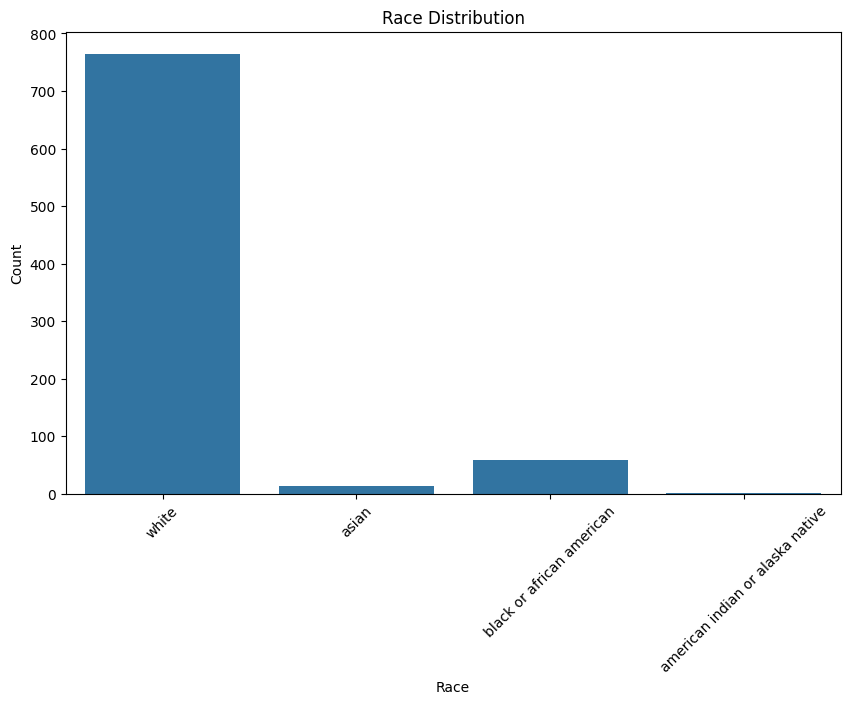

In [15]:
# Race distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Race', data=data)
plt.title("Race Distribution")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

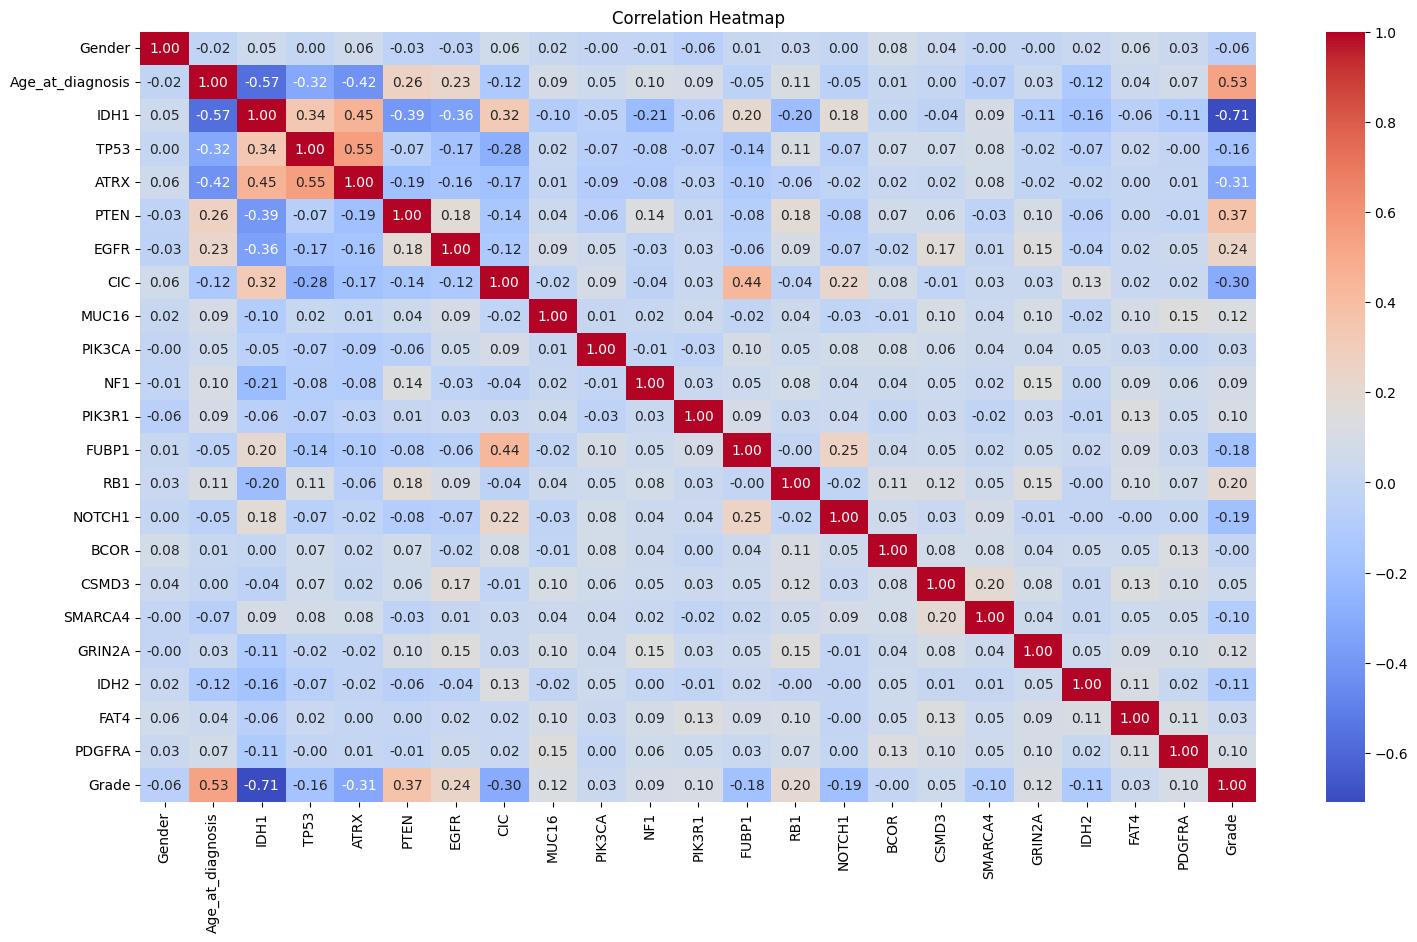

In [19]:
# Correlation heatmap for numeric features only
plt.figure(figsize=(18, 10))
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

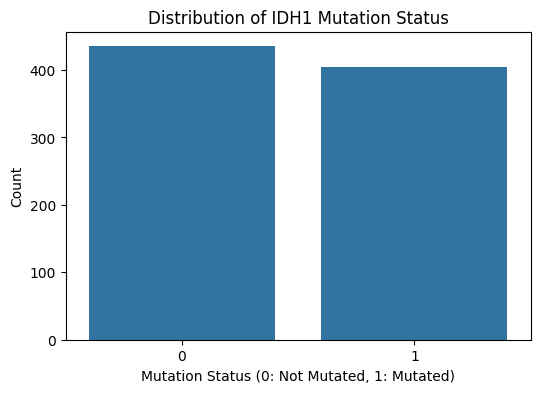

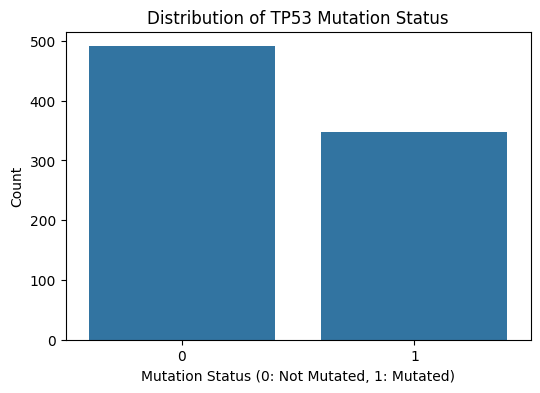

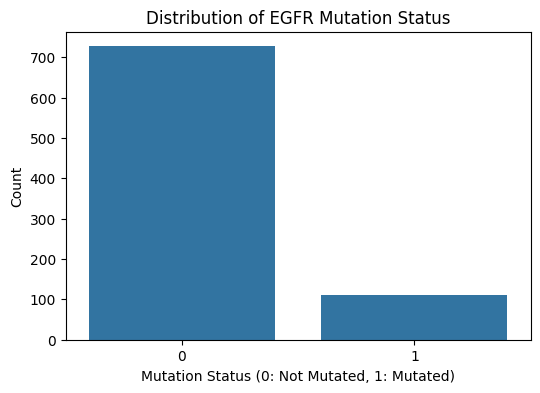

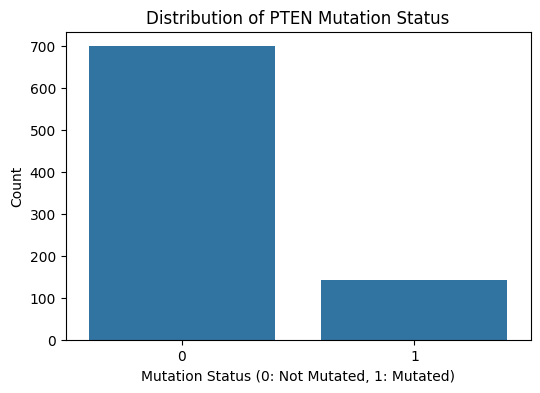

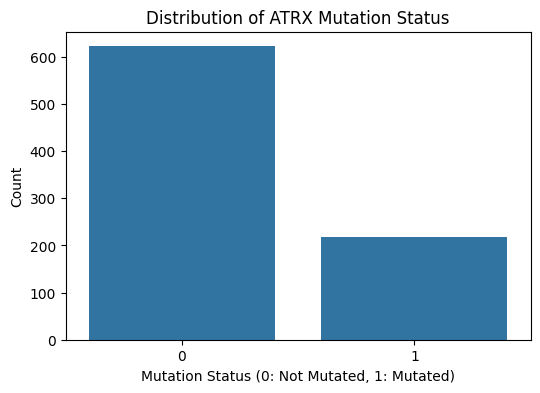

In [17]:
# Analyzing mutation status for specific genes
mutation_genes = ['IDH1', 'TP53', 'EGFR', 'PTEN', 'ATRX']
for gene in mutation_genes:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=gene, data=data)
    plt.title(f"Distribution of {gene} Mutation Status")
    plt.xlabel("Mutation Status (0: Not Mutated, 1: Mutated)")
    plt.ylabel("Count")
    plt.show()

In [30]:
from sklearn.preprocessing import LabelEncoder

# Drop unnecessary non-numeric columns (e.g., IDs if any)
data = data.drop(columns=['Patient_ID'], errors='ignore')  # Replace 'Patient_ID' with actual ID column name if needed

# Separate features (X) and target (y)
X = data.drop(columns=['Grade'])  # Assuming 'Grade' is the target column
y = data['Grade']

# Apply Label Encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)



Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5133 - loss: 8.4538 - val_accuracy: 0.6618 - val_loss: 2.7957
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5955 - loss: 2.2077 - val_accuracy: 0.7059 - val_loss: 0.7092
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6810 - loss: 0.7121 - val_accuracy: 0.9118 - val_loss: 0.3075
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8232 - loss: 0.3509 - val_accuracy: 0.8971 - val_loss: 0.2554
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8937 - loss: 0.2972 - val_accuracy: 0.9412 - val_loss: 0.2324
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9188 - loss: 0.2648 - val_accuracy: 0.9706 - val_loss: 0.2300
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9344 - loss: 0.2557 - val_accuracy: 0.9118 - val_loss: 0.1680
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9010 - loss: 0.2178 - val_accuracy: 1.0000 - val_loss

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)
print(f"MLP Test Accuracy (from model): {mlp_accuracy:.2f}")

# Get predictions for X_test
y_pred = (mlp_model.predict(X_test) > 0.5).astype("int32")  # Threshold predictions at 0.5

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9736 - loss: 0.1263 
MLP Test Accuracy (from model): 0.96
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.96
Precision: 0.99
Recall: 0.94
F1 Score: 0.96
